# Part 2: Training the Age & Gender Prediction Model

This notebook builds and trains a multi-output model to predict both age (a regression task) and gender (a classification task) from facial images using the **UTKFace** dataset.

## 1. Import Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm # For progress bars
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout


## 2. Define Constants and Configuration

In [ ]:
#  path to point to your UTKFace dataset directory.
BASE_DIR = r"C:\\Users\\harsh\\Documents\\Infosys\\UTKFace"
IMG_WIDTH = 128
IMG_HEIGHT = 128

## 3. Load and Parse Dataset Labels
The UTKFace dataset helpfully encodes labels in the filenames: `[age]_[gender]_[race]_[date&time].jpg`

Gender: 0 for Male, 1 for Female.

In [6]:
# Initialize lists to hold image paths and labels
image_paths = []
age_labels = []
gender_labels = []

print("Parsing filenames to extract labels...")
for filename in tqdm(os.listdir(BASE_DIR)):
    try:
        image_path = os.path.join(BASE_DIR, filename)
        temp = filename.split('_')
        age = int(temp[0])
        gender = int(temp[1])
        
        # Some files might not follow the format, skip them
        if 0 < age < 120: # A reasonable age range to filter out bad labels
            image_paths.append(image_path)
            age_labels.append(age)
            gender_labels.append(gender)
    except Exception as e:
        print(f"Skipping file {filename} due to error: {e}")

# Create a DataFrame for easier data manipulation
df = pd.DataFrame({'image': image_paths, 'age': age_labels, 'gender': gender_labels})
print(f"\nLoaded {len(df)} images.")
df.head()


Parsing filenames to extract labels...


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\\\Users\\\\harsh\\\\Documents\\\\Infosys\\\\UTKFace'

## 4. Exploratory Data Analysis (EDA)

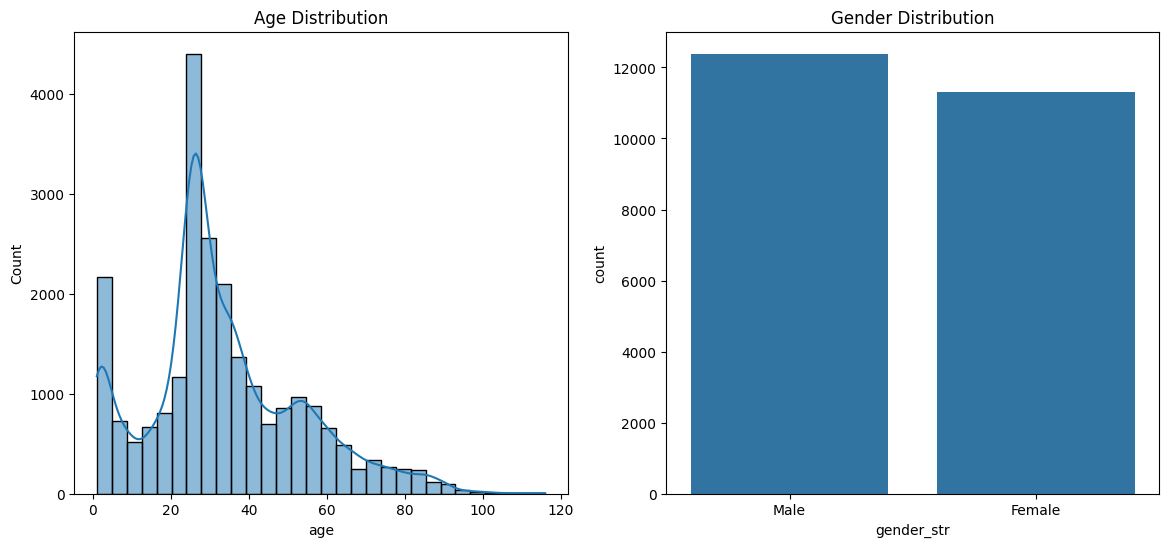

In [ ]:
# Visualize the distribution of age and gender in our dataset.
gender_dict = {0: 'Male', 1: 'Female'}
df['gender_str'] = df['gender'].map(gender_dict)

# Plot age distribution
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Age Distribution')

# Plot gender distribution
plt.subplot(1, 2, 2)
sns.countplot(x='gender_str', data=df)
plt.title('Gender Distribution')
plt.show()


## 5. Prepare Image Data
We'll create a function to load, resize, and convert images to grayscale numpy arrays.

The final array will be normalized.

In [ ]:
def extract_features(images):
    """Loads, resizes, and converts a list of image paths to a normalized numpy array."""
    features = []
    for image_path in tqdm(images):
        img = load_img(image_path, color_mode='grayscale', target_size=(IMG_WIDTH, IMG_HEIGHT))
        img = np.array(img)
        features.append(img)
    
    features = np.array(features)
    # Reshape for the CNN input: (num_samples, height, width, channels)
    features = features.reshape(len(features), IMG_HEIGHT, IMG_WIDTH, 1)
    return features

X = extract_features(df['image'])

# Normalize the image data to [0, 1] range
X = X / 255.0

print(f"Shape of image data tensor: {X.shape}")


  0%|          | 0/23708 [00:00<?, ?it/s]

Shape of image data tensor: (23708, 128, 128, 1)


## 6. Prepare Labels
Our model has two outputs, so we need two sets of labels.

In [ ]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

print(f"Shape of gender labels: {y_gender.shape}")
print(f"Shape of age labels: {y_age.shape}")


Shape of gender labels: (23708,)
Shape of age labels: (23708,)


## 7. Build the Multi-Output CNN Model

This model has one input and branches into two separate outputs: one for gender and one for age.

In [ ]:
# Define the input layer
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))

# Convolutional base (shared by both tasks)
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)

conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)

conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)

conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(maxp_4)

# --- Gender Branch ---
dense_gender = Dense(256, activation='relu')(flatten)
dropout_gender = Dropout(0.3)(dense_gender)
output_gender = Dense(1, activation='sigmoid', name='gender_out')(dropout_gender)

# --- Age Branch ---
dense_age = Dense(256, activation='relu')(flatten)
dropout_age = Dropout(0.3)(dense_age)
output_age = Dense(1, activation='relu', name='age_out')(dropout_age) # 'relu' ensures age is non-negative

# Create the model
model = Model(inputs=[inputs], outputs=[output_gender, output_age])

# Compile the model
# We define a separate loss function for each output.
model.compile(
    optimizer='adam',
    loss={'gender_out': 'binary_crossentropy', 'age_out': 'mae'}, # MAE: Mean Absolute Error
    metrics={'gender_out': 'accuracy', 'age_out': 'mae'}
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 12,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 6, 256) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 9216)      │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  2,359,552 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │  2,359,552 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_out (Dense)  │ (None, 1)         │        257 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_out (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,107,458 (19.48 MB)

 Trainable params: 5,107,458 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

## 8. Train the Model

In [ ]:
history = model.fit(
    x=X,
    y={'gender_out': y_gender, 'age_out': y_age},
    batch_size=32,
    epochs=30,
    validation_split=0.2 # Use 20% of the data for validation
)

# Save the trained model
model.save('age_gender_model.h5')
print("Model saved as age_gender_model.h5")


Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 259s 405ms/step - age_out_loss: 9.8462 - age_out_mae: 9.8464 - gender_out_accuracy: 0.5704 - gender_out_loss: 0.6570 - loss: 10.5036 - val_age_out_loss: 29.9821 - val_age_out_mae: 30.1101 - val_gender_out_accuracy: 0.7041 - val_gender_out_loss: 0.5636 - val_loss: 30.6753
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 272s 459ms/step - age_out_loss: 7.3820 - age_out_mae: 7.3816 - gender_out_accuracy: 0.7877 - gender_out_loss: 0.4479 - loss: 7.8295 - val_age_out_loss: 27.6281 - val_age_out_mae: 27.7409 - val_gender_out_accuracy: 0.7632 - val_gender_out_loss: 0.4938 - val_loss: 28.2353
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 410s 691ms/step - age_out_loss: 6.7662 - age_out_mae: 6.7644 - gender_out_accuracy: 0.8311 - gender_out_loss: 0.3759 - loss: 7.1402 - val_age_out_loss: 29.4104 - val_age_out_mae: 29.5358 - val_gender_out_accuracy: 0.7845 - val_gender_out_loss: 0.4584 - val_loss: 29.9957
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 243s 354ms/step - age_out_

Model saved as age_gender_model.h5


## 9. Evaluate Model Performance
We'll plot the training history for both tasks.

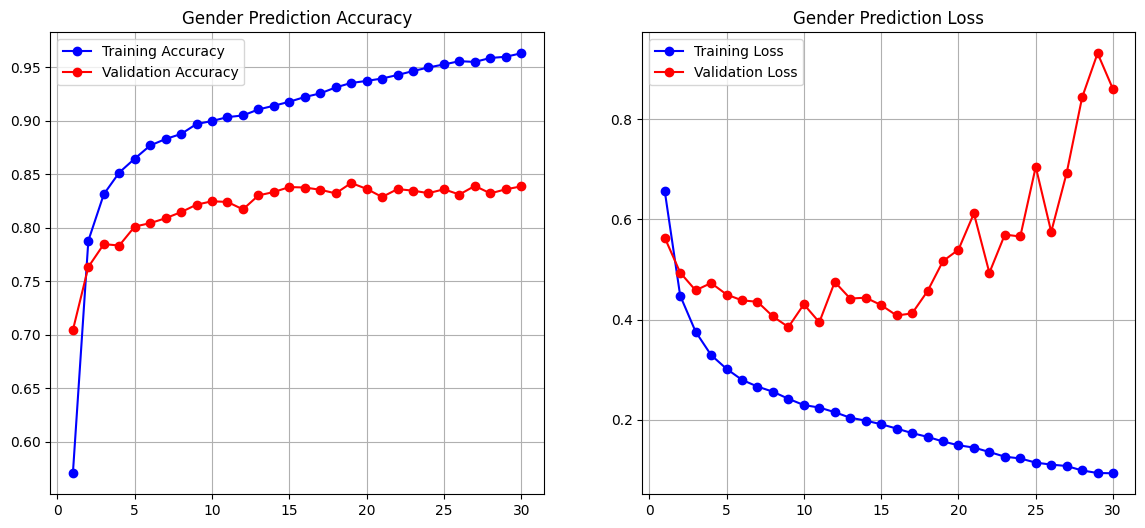

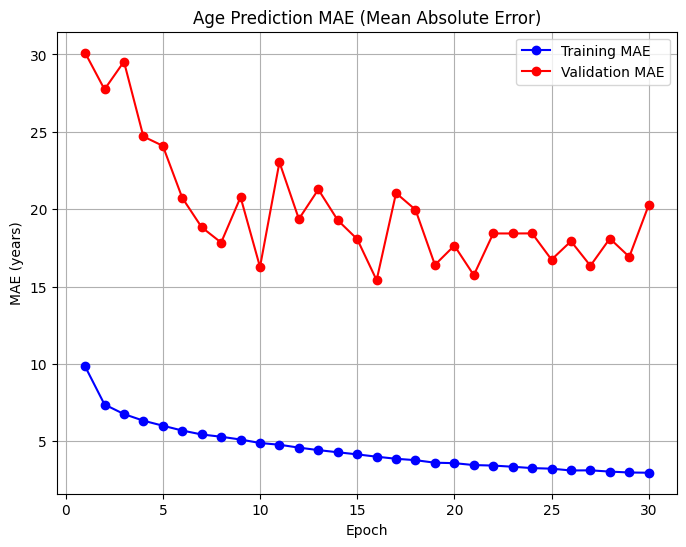

In [ ]:
# Plot history for gender prediction
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Gender Prediction Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Gender Prediction Loss')
plt.grid(True)
plt.legend()
plt.show()

# Plot history for age prediction (MAE)
mae = history.history['age_out_mae']
val_mae = history.history['val_age_out_mae']

plt.figure(figsize=(8, 6))
plt.plot(epochs, mae, 'bo-', label='Training MAE')
plt.plot(epochs, val_mae, 'ro-', label='Validation MAE')
plt.title('Age Prediction MAE (Mean Absolute Error)')
plt.xlabel('Epoch')
plt.ylabel('MAE (years)')
plt.grid(True)
plt.legend()
plt.show()


## 10. Test on a Single Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Original -> Gender: Male, Age: 14
Predicted -> Gender: Male, Age: 16


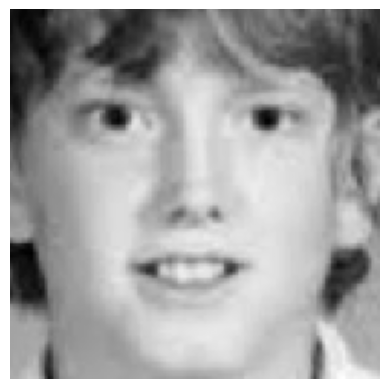

In [ ]:
def test_model(image_index):
    """Predicts age and gender for a single image and displays the result."""
    original_gender = gender_dict[y_gender[image_index]]
    original_age = y_age[image_index]
    
    # Get the image data and reshape for prediction
    img_to_predict = X[image_index].reshape(1, IMG_HEIGHT, IMG_WIDTH, 1)
    
    # Predict from model
    pred_gender_prob, pred_age = model.predict(img_to_predict)
    
    # Process predictions
    pred_gender = gender_dict[round(pred_gender_prob[0][0])]
    pred_age = round(pred_age[0][0])
    
    print(f"Original -> Gender: {original_gender}, Age: {original_age}")
    print(f"Predicted -> Gender: {pred_gender}, Age: {pred_age}")
    
    # Display the image
    plt.imshow(X[image_index].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
    plt.axis('off')
    plt.show()

# Test on a random image index
test_model(image_index=500)
# %%

## Run the below cells only for testing the model inside this notebook.

(NOTE: Don't forget to change the path of the model where you have saved it. Also update the path of the test image)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define constants needed for prediction
IMG_WIDTH = 128
IMG_HEIGHT = 128
gender_dict = {0: 'Male', 1: 'Female'}

# Load the model architecture and weights without the training config
print("Loading age and gender model...")
model = load_model(r'C:\\Users\\harsh\\Documents\\DermalScan\\models\\age_gender_model.h5', compile=False)

# Re-compile the model with its original settings to restore it completely
model.compile(
    optimizer='adam',
    loss={'gender_out': 'binary_crossentropy', 'age_out': 'mae'},
    metrics={'gender_out': 'accuracy', 'age_out': 'mae'}
)

print("Model loaded and re-compiled successfully!")

Loading age and gender model...
Model loaded and re-compiled successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


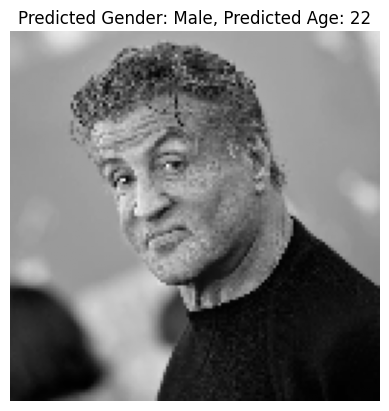

In [2]:
# IMPORTANT: Set the path to the image you want to test
image_path_to_test = r'C:\\Users\\harsh\\Documents\\DermalScan\\datasets\\skin_dataset\\wrinkles\\254.jpg' # <-- CHANGE THIS

try:
    # Preprocess the image
    img = load_img(image_path_to_test, color_mode='grayscale', target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) # Create a batch
    img_array = img_array / 255.0 # Normalize

    # Make prediction
    pred_gender_prob, pred_age = model.predict(img_array)
    
    # Process predictions
    pred_gender = gender_dict[round(pred_gender_prob[0][0])]
    pred_age = round(pred_age[0][0])

    # --- Display the results ---
    
    # Display the image with the predictions
    plt.imshow(img, cmap='gray')
    plt.title(f'Predicted Gender: {pred_gender}, Predicted Age: {pred_age}')
    plt.axis('off')
    plt.show()

except FileNotFoundError:
    print(f"Error: The file was not found at {image_path_to_test}")
    print("Please update the 'image_path_to_test' variable with a valid path.")
except Exception as e:
    print(f"An error occurred: {e}")